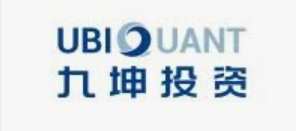

# Exploratory Data Analysis of the Competition Target

@marketneutral

Please also see my other three Ubiquant notebooks:
- [Ubiquant Feature Exploration](https://www.kaggle.com/marketneutral/ubiquant-feature-exploration)
- [Stacking & Feature Importance](https://www.kaggle.com/marketneutral/stacking-feature-importance)
- [Robust Multi-Target PyTorch](https://www.kaggle.com/marketneutral/robust-multi-target-pytorch) - This notebook uses the completed targets generated in this notebook.


## Updated!

### Version Notes
- (1) Version 2 released Feb 1, 2022
- (2) Version 3 released Feb 3, 2022
    - added Quandl WIKI US Equities Price data
    - created targets from this data (5d zscored)
    - ran PCA magic matrix completion test on US Equity data
- (3) Version 4 released Feb 7, 2022
    - ran test for LGBMImputer and compared with PCA magic
    - moved competition data completion to LGBMImputer

<div class="alert alert-warning">
<b>TL;DR:</b> In tabular data, it is often helpful to do feature engineering (i.e., transform and/or combine features). In this competition, the features are obfuscated and therefore it is difficult to use any domain experience to perform feature engineering. This notebook looks at the target and seeks to create a cluster feature based on the `investment_id`. This should be of value as it is likely an indicator of investment id characteristics such as sector/industry membership. To cluster we need a nice rectangular matrix with all the targets and id's. However when you try to make this matrix, you will see significant missing values. We try two imputation strategies to fill in the missing data in a sophisticated way. The `LightGBM` imputer by @analokmaus works very well.
</div>

# What's Really Going on With the Data?

What is this data all about? What are we trying to achieve? In this competition, we are given a large number of **cross-sectional** **alphas** and a training label which represents a transformed forward return for a given `investment_id`. Cross-sectional means that for a given `time_id`, an alpha is meant to be able to sort effectively the universe of invesments for that `time_id`. "Sort effectively" means to create a vector which is, as best as possible, directly proportionate the the target. There is quite a bit on information in the public domain which describes this style of investing in detail. The paper [101 Formulaic Alphas](https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf) describes in detail how, generally, the features `f_0` to `f_299` are generated. The book [Finding Alphas](https://www.amazon.com/Finding-Alphas-Quantitative-Approach-Strategies/dp/1119571219/) is also specificially about the style of investing in this competition. That paper and book will give you a very good sense of how the features were designed. It is our task to **combine the alphas** into a master alpha...also known as designing a meta model.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install hdbscan

In [ ]:
!git clone https://github.com/marketneutral/kuma_utils.git
%cd kuma_utils
!git checkout lgb_add_tqdm
%cd ..
import sys
sys.path.append("kuma_utils/")

In [ ]:
import gc, random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap, hdbscan
import missingno as msno

from kuma_utils.preprocessing.imputer import LGBMImputer
from ppca import PPCA

from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler

from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster import hierarchy

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 5)

# Load and Inspect the Data

Thanks [Rob Mulla](https://www.kaggle.com/robikscube) for the reduced memory version of the data.

In [ ]:
%%time
train = (pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
         .sort_values(['investment_id', 'time_id']));

Let's take a peak and see what the data looks like.

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.isnull().sum().sum()

In [ ]:
all_columns = train.columns
features = all_columns[train.columns.str.contains('f_')]

# Plots of Targets Time Series

Each `investment_id` is a stock. How do the targets look for a random of 10 stocks?

In [ ]:
sample_tickers = random.sample(list(train.investment_id.unique()), 10)

(train
 .query('investment_id in @sample_tickers')
 .set_index(['time_id', 'investment_id'])['target']
 .unstack()
 .plot(alpha=0.4,
       title='Time Series Plot of the Target (sampled tickers)'));

From the organizers, 

> In this competition, you’ll build a model that forecasts an investment's return rate

This, and my domain experience in this world, suggests that the targets are the forward returns from the `time_id` for a certain period. If this period is **more than** the increment of the `time_id` then the targets will overlap in time. For example, if the `time_id`s are daily, and the forward returns are monthly, then there will be substantial overlap. This has implication for the IID assumption underlying most models (beyond the scope of this notebook). If the targets are overlapping in time, this will show up as strong positive autocorrelation in the per stock time series of targets. **We do see this generally** (but the number of missing values is massive).

In [ ]:
(train
 .query('investment_id in @sample_tickers')
 .set_index(['time_id', 'investment_id'])['target']
 .unstack()
 .rolling(120)
 .apply(lambda x: x.autocorr(), raw=False)
 .plot(alpha=0.4,
       title='Time Series Plot of Rolling Autocorrelation of the Target (sampled tickers)')
 .legend(loc='lower center',
         ncol=len(sample_tickers)));
plt.axhline(0);

In looking at the target it's helpful to reshape the dataframe to be `time_id` in the index, `investment_id` in the columns, and `target` in the values.

In [ ]:
targets_wide = (
    train
    .filter([
        'time_id',
        'investment_id',
        'target'])
    .set_index(['time_id', 'investment_id'])
    .unstack()
    .droplevel(0, axis=1))

targets_wide.shape

In [ ]:
sample_days = random.sample(list(train.time_id.unique()), 20)

(train
 .query('time_id in @sample_days')
 .set_index(['time_id', 'investment_id'])['target']
 .unstack()
 .T
 .plot.kde(title='Cross Sectional Distribution of the Target on a sample of 20 days', legend=False));

It appears that the Target has been roughly standardized cross-sectionally per day (i.e., for each day, take the zscore across all stocks).

In [ ]:
(targets_wide
 .std(axis=1)
 .plot(title="Per Day Cross Sectional Standard Deviation of Target"))

plt.axhline(1.0, linestyle='--')
plt.axvspan(355, 420, color='red', alpha=0.2)

In [ ]:
(targets_wide
 .mean(axis=1)
 .plot(title="Per Day Cross Sectional Mean of Target"))
plt.axhline(0.0, linestyle='--')
plt.axvspan(355, 420, color='red', alpha=0.2)

Something odd is going on in the date range of approx. 355 to 420. Perhaps we want to drop these days during training.

What percent of missing data do we have now?

In [ ]:
targets_wide.isnull().sum().sum() / targets_wide.size

Yikes! When we align all the targets in a time series by date, we have 27.5% missing data! This means that, as is, you cannot reliably make rolling or lag versions of the features. Let's see this visually in `missingno`, a wonderful viz package. The `y` axis is `time_id` from 1 to 1211. Each element across the `x` axis is a time series of the target. I've sampled down the dataframe for viz purposes. In fact, there is one stock which has data for only 2 of 1211 days! 115 tickers have missing days over 1000 of the 1209 days. These we are going to remove.

In [ ]:
(targets_wide
 .isnull()
 .sum(axis=0)
 .max(),

(targets_wide
 .isnull()
 .sum(axis=0) > 1_000
).sum())

In [ ]:
targets_wide = (
    targets_wide
    .iloc[:, list(~(targets_wide.isnull().sum(axis=0) > 1_000))])

In [ ]:
(msno.matrix(
    targets_wide.sample(n=250, axis=1),
    figsize=(16, 5),
    width_ratios=(20,1),
    fontsize=10,
    labels=None)
      .set_title('Data Completeness; Targets (250 samples) vs Time'));

# Matrix Completion of Missing Targets
## Probabalistic PCA vs. LGBMImputer

Let's try to fill in the missing data intelligently. First we try matrix completion using **probabalistic PCA** using the aptly named package "PCA Magic" which implements the ideas in [this paper](https://www.apps.stat.vt.edu/leman/VTCourses/PPCA.pdf). As described in the [package repository](https://github.com/allentran/pca-magic):

>A better way: suppose you had the latent factors representing the matrix. Construct a linear model for each series and then use the resulting model for interpolation. Intuitively, this will preserve the signal from the data as the interpolated values come from latent factors. However, the problem is you never have these factors to begin with. The old chicken and egg problem. But no matter, fixed point algorithms via Probabilistic PCA to the rescue.

The algorithm does not scale well with N so we break up the stock universe into chunks and then combine them at the end. There is *some* information loss in doing this.

I recently watched [**"Handling Missing Values"**](https://www.youtube.com/watch?v=EYySNJU8qR0) session on Abhishek Thakur's YouTube channel featuring [Rob Mulla](). The final section in that session talks about iteratively imputing missing values. He uses code by Kaggle master [RabotniKuma](https://www.kaggle.com/analokamus) which uses LightGBM as the imputer. This a really creative application of LightGBM and it dramatically outperforms imputation by probabalistic PCA. Let's see!

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def run_proba_PCA_chunked(df, chunk_size=1000, n_comp=50):
    """Run Prob PCA over a dataframe, chunked into smaller sizes.
    We do this becuase it is much much faster.
    """
    
    # we shuffle the columns just to be safe
    initial_cols = list(df.columns)
    cols = initial_cols.copy()
    random.shuffle(cols)
    
    chunk_holder = []
    ppca_holder = []
    
    for chunk in tqdm(list(chunks(cols, chunk_size))):
        
        # PPCA automatically scales the data, but we want to do it
        # ourselves so we can reconstruct later
        scaler = StandardScaler()
        
        chunk_matrix = df[chunk].values
        
        scaler.fit(chunk_matrix)
        returns = scaler.transform(chunk_matrix)

        ppca = PPCA()
        ppca.fit(data=returns, d=n_comp, verbose=False, tol=1e-4)
        ppca_holder.append(ppca)
        
        completed = pd.DataFrame(
            ppca.data,
            index=df.index,
            columns=chunk
        )

        reconst = pd.DataFrame(
            scaler.inverse_transform(completed),
            index=df.index,
            columns=chunk
        )
        
        chunk_holder.append(reconst)
        
    return pd.concat(chunk_holder, axis=1)[initial_cols], ppca_holder

# A Sidebar Excursion with Known Real Market Data

Before we dive into seeing if we can reliably fill in the missing data and perfom further analysis, let's check how targets would look on known, real market data. I've attached the [Quandl WIKI PRICES]() Dataset, which I just added to Kaggle Datasets this past week. If you have spent time in the quant finance space, you will remember that Quandl (since acquired by Nasdaq) used to produce a free public domain dataset of end-of-day open/high/low/close/volume/div and split/spinoff factor dataset for ~3,000 US stocks. This dataset was an extraordinary resource for the community, but unfortunately they ceased producing it in April 2018. The date range in this dataset is from January 2, 1962 to March 27, 2018 and contains > 15 million rows. Even though the data does not extend to today, we can use the historical data to investigate

- what structure do we see in 1-week, 2-week, and 1-month forward returns?
- if we purposely remove datapoints, can we reliably infer them back?

In [ ]:
%%time
quandl_wiki = pd.read_csv(
    '../input/quandl-wiki-prices-us-equites/WIKI_PRICES.csv'
)

In [ ]:
print(f"Date range: {(quandl_wiki['date'].min(), quandl_wiki['date'].max())}")

In [ ]:
quandl_wiki.head()

In [ ]:
quandl_wiki.info()

The competition data looks like it is ~5 years of data. Let's query down our Wiki dataset to that size.

In [ ]:
quandl_wiki = (
    quandl_wiki.filter(['ticker', 'date', 'adj_close'])
    .query('date > "2013-03-01"')
    .reset_index(drop=True))

In [ ]:
print(f"Count of unique tickers: {quandl_wiki['ticker'].nunique()}")

Now we make our targets... 1-week z-scored crossectionally.

In [ ]:
wiki_target_1w_zs = (quandl_wiki
 .set_index(['date', 'ticker'])
 .unstack()
 .pct_change(periods=5)
 .apply(zscore, nan_policy = 'omit', axis=1)
 .dropna(how='all', axis=1)
 .clip(-15, 15)
 .iloc[5:, :])

In [ ]:
wiki_target_1w_zs.shape

We cut out stocks that have 1,000 or more missing points.

In [ ]:
wiki_target_1w_zs = (
    wiki_target_1w_zs
    .iloc[:, list(~(wiki_target_1w_zs.isnull().sum(axis=0) > 1_000))])

Looking at the autocorrelation of these targets... The results suggest that this target constuction is **not** equivalent to the competition. If we run this on one day returns, we see slightly negative autocorrelation (this is consistent with the known stylized effect of short-dated mean reversion). Ubiquant must be doing something different to make these targets ... or perhaps these are not stocks. I find it unlikely though to imagine that the competition targets are not stocks since we have over 3000 unique `investment_id` (I'm not sure there is another market with that level of cardinality than stocks).

In [ ]:
(wiki_target_1w_zs
 .sample(10, axis=1)
 .rolling(120)
 .apply(lambda x: x.autocorr(), raw=False)
 .plot(alpha=0.4,
       title='Time Series Plot of Rolling Autocorrelation of the Target (sampled tickers)'))
plt.axhline(0);

Generally we see much lower missing data in the WIKI dataset than in the competition.

In [ ]:
(msno.matrix(
    wiki_target_1w_zs.sample(n=250, axis=1),
    figsize=(16, 5),
    width_ratios=(20,1),
    fontsize=10,
    labels=None)
      .set_title('Data Completeness; Wiki 1w Targets (250 samples) vs Time'));

In [ ]:
(wiki_target_1w_zs
 .sample(20)
 .dropna(how='all', axis=1)
 .T
 .plot.kde(title='Cross Sectional Distribution of the 1m Wiki Target on a sample of 20 days', legend=False));

In [ ]:
sample_tickers = random.sample(list(wiki_target_1w_zs.columns), 10)

(wiki_target_1w_zs
.loc[:, wiki_target_1w_zs.columns.isin(sample_tickers)]
.plot(alpha=0.4, title='Time Series Plot of of the 1m Wiki Target'));

In [ ]:
wiki_target_1w_zs.shape

To test imputation, we are to make a dataset where we purposely inject `nan` for data points we know. We then imput these and look at the reconstruction error.

In [ ]:
wiki_target_1w_baseline = (
    wiki_target_1w_zs.dropna()
                     .droplevel(level=0, axis=1))

In [ ]:
wiki_target_1w_baseline.head()

We purposely add a couple blocks of `nan` values in order to test the reconstruction algorithm.

In [ ]:
wiki_target_1w_zs_naned = wiki_target_1w_baseline.copy()
wiki_target_1w_zs_naned.iloc[200:300, 2900:] = np.nan
wiki_target_1w_zs_naned.iloc[0:100, 0:100] = np.nan

In [ ]:
plt.imshow(wiki_target_1w_zs_naned)
plt.title("Masked Return DataFrame (white = nan'ed points)")
plt.xlabel('ticker')
plt.ylabel('date');

In [ ]:
(msno.matrix(
    wiki_target_1w_zs_naned.sample(n=250, axis=1),
    figsize=(16, 5),
    width_ratios=(20,1),
    fontsize=10,
    labels=None)
      .set_title('Data Completeness; Wiki 1w Targets Masked (250 samples) vs Time'));

Impute using probabalistic PCA.

In [ ]:
n_comp = 50
reconst_wiki_1w, ppca_list_wiki_1w = run_proba_PCA_chunked(
    wiki_target_1w_zs_naned,
    chunk_size = 1000,
    n_comp = n_comp
)

Impute using @analokmaus' LightGBM imputer.

In [ ]:
%%time

lgbm_imtr = LGBMImputer(n_iter=5, verbose=True)
reconst_wiki_1w_lgb = (
    lgbm_imtr.fit_transform(pd.DataFrame(wiki_target_1w_zs_naned.values)))

For the two methods, let's look at the RMSE for the nan'ed sections of the DataFrame.

In [ ]:
print(f"LGB Imputer error: {np.sqrt(((wiki_target_1w_baseline.values - reconst_wiki_1w_lgb.values)[:100, :100]**2).sum()/10000)}")

In [ ]:
print(f"Prob PCA error: {np.sqrt(((wiki_target_1w_baseline - reconst_wiki_1w).iloc[:100, :100]**2).sum().sum()/10000)}")

When we compare the two strategies visually, we can also see that LightGBM Imputer performs significantly better.

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig.tight_layout()

sns.heatmap(
    pd.DataFrame(
        (wiki_target_1w_baseline.values - reconst_wiki_1w.values))
         .iloc[:100,:100],
    xticklabels=False,
    yticklabels=False,
    cmap='vlag',
    ax=ax[0],
    vmin=-15, vmax=15
).set(
    title="Reconstruction Error (Prob PCA)",
    xlabel="ticker");

sns.heatmap(
    pd.DataFrame(
        (wiki_target_1w_baseline.values - reconst_wiki_1w_lgb.values))
         .iloc[:100,:100],
    xticklabels=False,
    yticklabels=False,
    cmap='vlag',
    ax=ax[1],
    vmin=-15, vmax=15
).set(
    title="Reconstruction Error (LightGBM Imputer)",
    xlabel="ticker");


plt.show()

The reconstruction error for LightGBM **looks** acceptable.

Lastly, let's look at the *structure* of this 1m wiki target.

In [ ]:
plt.bar(np.arange(n_comp)+1,
        np.diff(np.append([0], ppca_list_wiki_1w[0].var_exp)))
plt.title('Percent of Variance Explained by Each Component (1m Wiki Target)');

# Reconstituting the Competition Target

In [ ]:
del wiki_target_1w_zs_naned
del reconst_wiki_1w
del wiki_target_1w_baseline
del reconst_wiki_1w_lgb
del wiki_target_1w_zs
del quandl_wiki

In [ ]:
gc.collect()

In [ ]:
targets_wide.head()

In [ ]:
n_comp = 50
_, ppca_list = run_proba_PCA_chunked(
    targets_wide,
    chunk_size = 1000,
    n_comp = n_comp
)

In [ ]:
%%time

lgbm_imtr = LGBMImputer(n_iter=5, verbose=False)
reconst = (
    lgbm_imtr.fit_transform(pd.DataFrame(targets_wide.values)))

In [ ]:
reconst.to_csv('target_lgb_filled.csv')

In [ ]:
# and...we filled in the data!
(msno.matrix(
    reconst.sample(n=100, axis=1),
    figsize=(16, 5),
    width_ratios=(20,1),
    fontsize=10,
    labels=None)
      .set_title('Data After Matrix Completion; Targets (sampled) vs Time'));

In [ ]:
sample_tickers = random.sample(list(reconst.columns), 10)

(reconst
.loc[:, reconst.columns.isin(sample_tickers)]
.plot(alpha=0.4, title='Time Series Plot of of the Target (Completed)'));

In [ ]:
(reconst
 .loc[:, reconst.columns.isin(sample_tickers)]
 .rolling(120)
 .apply(lambda x: x.autocorr(), raw=False)
 .plot(alpha=0.4,
       title='Time Series Plot of Rolling Autocorrelation of the Target')
 .legend(loc='lower center',
         ncol=len(sample_tickers)))
plt.axhline(0);

What we observe in the plot is that the targets have significant positive autocorrelation. To me this means that these targets are **forward return periods which are overlapping**. For example, maybe the forward 5-day or 10-day return, then normalized or transformed somehow. Let's look at the underlying "structure" of the time series of the targets. If the targets are returns we will see the common pattern in equity markets where the first principle component makes ~30% of the variance.

In [ ]:
plt.bar(np.arange(n_comp)+1,
        np.diff(np.append([0], ppca_list[0].var_exp)))
plt.title('Percent of Variance Explained by Each Component');

Ok, so there is *some* structure in the data. As just mentioned, if these were typical, untransformed stock returns, you would see the first component explain closer to 30% of the variance (as we see in the Quandl Wiki 1m Target). The targets therefore must be neutralized to certain factors. We can better visualize this as a hierarchical correlation matrix.

# Visualizing the Hierarchical Correlation Matrix

We estimate the covariance matrix with the robust Ledoit Wolf estimation and pull out the correlation matrix. We then reorder the matrix to isolate the hierarchy.

In [ ]:
%%time

def get_corr_from_cov(covmat):
    """Factor out the correlation matrix from
    the covariance matrix"""
    d = np.diag(np.sqrt(np.diag(lw.covariance_)))
    return np.linalg.inv(d) @ lw.covariance_ @ np.linalg.inv(d)


lw = LedoitWolf()

lw.fit(reconst.values)
corr = get_corr_from_cov(lw.covariance_)

In [ ]:
def plot_hm(corr, title):
    
    row_linkage = hierarchy.linkage(
        distance.pdist(corr),
        method='average'
    )
    
    row_order = list(
        map(int,
            hierarchy.dendrogram(row_linkage, no_plot=True)['ivl'])
    )
    
    col_linkage = hierarchy.linkage(
        distance.pdist(corr.T)
        , method='average'
    )
    
    col_order = list(
        map(int,
            hierarchy.dendrogram(col_linkage, no_plot=True)['ivl'])
    )
    
    corr_swapped = np.copy(corr)
    corr_swapped[:, :] = corr_swapped[row_order, :]
    corr_swapped[:, :] = corr_swapped[:, col_order]

    fig = plt.figure(figsize=(12, 12))
    fig.tight_layout()
    ax = plt.gca()
    
    cs1 = sns.heatmap(
        corr_swapped,
        square=True,
        xticklabels=False,
        yticklabels=False,
        cbar=False,
        ax=ax,
        cmap='viridis'
    ).set_title(title)

We can see that there is indeed structure in the time series of the targets. Typically in stock financial time series, this structure comes from market sensitivity, industry membership (e.g., energy, industrials, etc.), or common style factors like value, momentum, low volatility, and size.

In [ ]:
title = 'Hierharical Correlation Matrix of Target (sampled)'
plot_hm(corr[0:1000, 0:1000], title)

# Clustering and Labeling the `investment_id`s with UMAP and HDBSCAN

Given that there is some structure, one idea is to make a per `invesment_id` cluster label. When used in, say, LightGBM, this feature could be a valiable feature to split on. Intuitively, you might think that certain stocks are better explained by certain alphas. For example, if you alpha is based on sentiment, then this alpha might do better with technology stocks (which trade more on sentiment as operating cash flows are typically deferred far forward in time). We cluster with `UMAP` and then find labels with `HDBSCAN`.

In [ ]:
%%time
clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.15,
    n_components=2,
    random_state=42,
).fit_transform(reconst.T)  # note the transform

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=15,
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)

In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=15,
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

ax.scatter(
    clusterable_embedding[clustered, 0],
    clusterable_embedding[clustered, 1],
    c=labels[clustered],
    s=20,
    cmap='viridis'
)

ax.scatter(
    clusterable_embedding[~clustered, 0],
    clusterable_embedding[~clustered, 1],
    c='grey',
    s=10,
    alpha=0.25,
    cmap='viridis'
)

ax.set_title('UMAP Clustered Targets, Colored by Cluster (gray is unclustered)');

This clustering could likely be improved, but the idea seems valid. Let's save the feature to use it in another notebook.

In [ ]:
label_feature = pd.DataFrame(
    index = reconst.columns,
    data={
        'investment_id': reconst.columns,
        'label_feature': labels
    }
)
label_feature.to_csv('label_feature', index=False)

Thank you for reading. Please leave comments, qustions, or suggestions below and I will do my best to address them.

Lastly a comment on Pandas style... I recently watched [Martin Henze (@headortails)](https://www.kaggle.com/headsortails) in his guest appearance on Abishek Thankur's [YouTube channel](https://www.youtube.com/channel/UCBPRJjIWfyNG4X-CRbnv78A). I was blown away by the [elegance of his work](https://www.youtube.com/watch?v=JXF-7rCcR1c) and the `tidyverse` in R. I was an R user for 15+ years before moving over to Python about 6 years ago. I moved to Python before the `tidyverse` really got going (in fact we all called the `hadleyverse` back then, but Hadley Wickham is so low ego that he changed the name officially to the `tidyverse`. Anyhow, I (and probably most of you) use Python and after seeing Martin's work, I feel I got conned. So...I am trying to use Pandas in the `tidyverse` style as much as possible, using method chaining and `.pipe(...)` if needeed. This is in the Modern Pandas style (see Tom Asburger's excellent [blog post](https://tomaugspurger.github.io/method-chaining)). This style is much easier to read and is more memory efficient in a notebook as you are not creating intermediate objects unecessarily.